In [2]:
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local").setAppName("My App")
sc = SparkContext(conf = conf)

In [3]:
user_data = sc.textFile("./ml-100k/u.user")
user_data.first()

u'1|24|M|technician|85711'

In [4]:
user_fields = user_data.map(lambda line: line.split("|"))

num_users = user_fields.map(lambda fields: fields[0]).count()
num_genders = user_fields.map(lambda fields: fields[2]).distinct().count()
num_occupations = user_fields.map(lambda fields: fields[3]).distinct().count()
num_zipcodes = user_fields.map(lambda fields: fields[4]).distinct().count()
print ("Users: %d, genders: %d, occupations: %d, ZIP codes: %d" % (num_users, num_genders, num_occupations, num_zipcodes))

Users: 943, genders: 2, occupations: 21, ZIP codes: 795


/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


(array([ 0.00064269,  0.00192808,  0.00449886,  0.0279572 ,  0.02956393,
         0.03374144,  0.04563129,  0.02538642,  0.02088756,  0.01863813,
         0.02088756,  0.01606735,  0.0170314 ,  0.01863813,  0.00674829,
         0.00482021,  0.0054629 ,  0.00192808,  0.00128539,  0.00128539]),
 array([  7. ,  10.3,  13.6,  16.9,  20.2,  23.5,  26.8,  30.1,  33.4,
         36.7,  40. ,  43.3,  46.6,  49.9,  53.2,  56.5,  59.8,  63.1,
         66.4,  69.7,  73. ]),
 <a list of 20 Patch objects>)

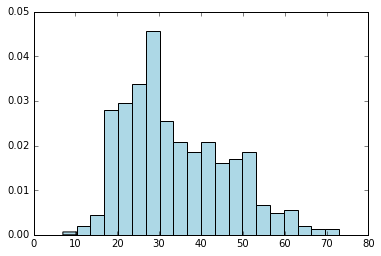

In [5]:
%pylab inline

import matplotlib.pyplot as plt

ages = user_fields.map(lambda x: int(x[1])).collect()
plt.hist(ages, bins=20, color='lightblue', normed=True)


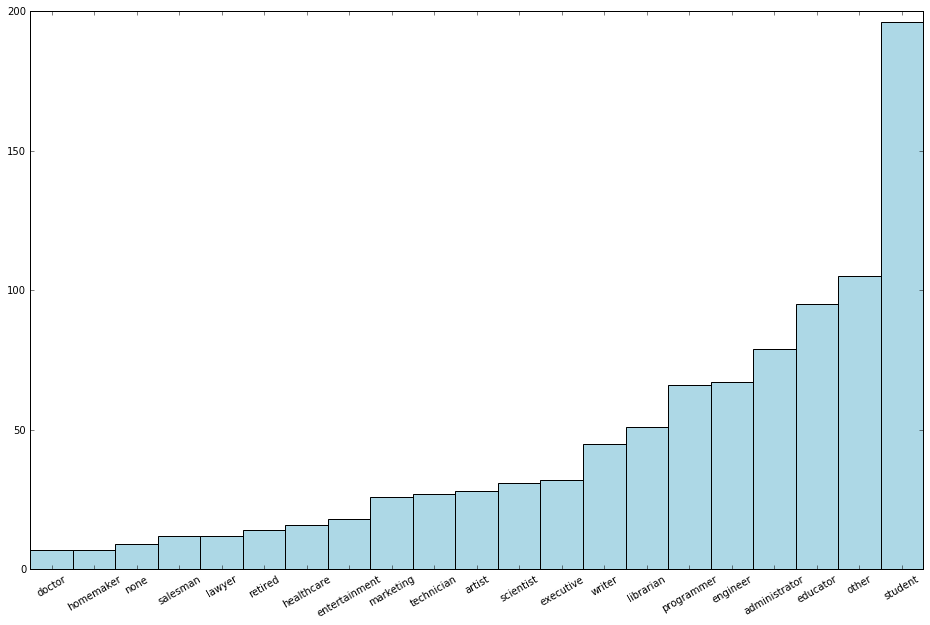

In [6]:
count_by_occupation = user_fields.map(lambda fields: (fields[3], 1)).reduceByKey(lambda x, y: x + y).collect()
x_axis1 = np.array([c[0] for c in count_by_occupation])
y_axis1 = np.array([c[1] for c in count_by_occupation])
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

pos = np.arange(len(x_axis))
width = 1.0

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis, width, color='lightblue')
plt.xticks(rotation=30)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

In [7]:
rating_data_raw = sc.textFile("./ml-100k/u.data")
num_ratings = rating_data_raw.count()

movie_data = sc.textFile("./ml-100k/u.item")
num_movies = movie_data.count()

In [8]:
def convert_year(x):
    try:
        return int(x[-4:])
    except:
        return 1900 # there is a 'bad' data point with a blank year, which we set to 1900 and will filter out later

movie_fields = movie_data.map(lambda lines: lines.split("|"))
years = movie_fields.map(lambda fields: fields[2]).map(lambda x: convert_year(x))
years_filtered = years.filter(lambda x: x != 1900)
movie_ages = years_filtered.map(lambda yr: 1998-yr).countByValue()
values = movie_ages.values()
bins = movie_ages.keys()
# plt.hist(values, bins=bins, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

In [9]:
rating_data = rating_data_raw.map(lambda line: line.split("\t"))
ratings = rating_data.map(lambda fields: int(fields[2]))
max_rating = ratings.reduce(lambda x, y: max(x, y))
min_rating = ratings.reduce(lambda x, y: min(x, y))
mean_rating = ratings.reduce(lambda x, y: x + y) / float(num_ratings)
median_rating = np.median(ratings.collect())
ratings_per_user = num_ratings / num_users
ratings_per_movie = num_ratings / num_movies

In [10]:
ratings.stats()

(count: 100000, mean: 3.52986, stdev: 1.12566797076, max: 5.0, min: 1.0)

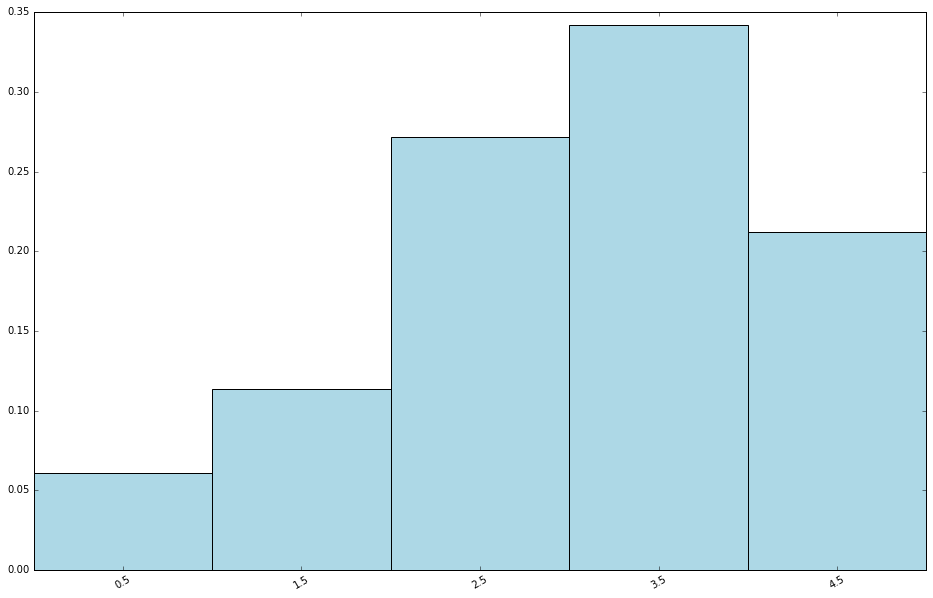

In [11]:
import numpy as np
# create plot of counts by rating value
count_by_rating = ratings.countByValue()
x_axis = np.array(count_by_rating.keys())
y_axis = np.array([float(c) for c in count_by_rating.values()])

# we normalize the y-axis here to percentages
y_axis_normed = y_axis / y_axis.sum()

pos = np.arange(size(x_axis))
width = 1.0

ax = plt.axes()
ax.set_xticks(pos + (width / 2))

plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

In [15]:
# to compute the distribution of ratings per user, we first group the ratings by user id
user_ratings_grouped = rating_data.map(lambda fields: (int(fields[0]), int(fields[2]))).groupByKey() 
# then, for each key (user id), we find the size of the set of ratings, which gives us the # ratings for that user 
user_ratings_byuser = user_ratings_grouped.map(lambda (k, v): (k, len(v)))
user_ratings_byuser.collect()

[(1, 272),
 (2, 62),
 (3, 54),
 (4, 24),
 (5, 175),
 (6, 211),
 (7, 403),
 (8, 59),
 (9, 22),
 (10, 184),
 (11, 181),
 (12, 51),
 (13, 636),
 (14, 98),
 (15, 104),
 (16, 140),
 (17, 28),
 (18, 277),
 (19, 20),
 (20, 48),
 (21, 179),
 (22, 128),
 (23, 151),
 (24, 68),
 (25, 78),
 (26, 107),
 (27, 25),
 (28, 79),
 (29, 34),
 (30, 43),
 (31, 36),
 (32, 41),
 (33, 24),
 (34, 20),
 (35, 25),
 (36, 20),
 (37, 57),
 (38, 121),
 (39, 22),
 (40, 35),
 (41, 52),
 (42, 183),
 (43, 221),
 (44, 151),
 (45, 48),
 (46, 27),
 (47, 25),
 (48, 66),
 (49, 215),
 (50, 24),
 (51, 23),
 (52, 56),
 (53, 28),
 (54, 65),
 (55, 21),
 (56, 187),
 (57, 106),
 (58, 154),
 (59, 382),
 (60, 208),
 (61, 21),
 (62, 232),
 (63, 93),
 (64, 200),
 (65, 80),
 (66, 38),
 (67, 30),
 (68, 34),
 (69, 65),
 (70, 131),
 (71, 38),
 (72, 137),
 (73, 66),
 (74, 39),
 (75, 79),
 (76, 82),
 (77, 72),
 (78, 21),
 (79, 55),
 (80, 29),
 (81, 58),
 (82, 168),
 (83, 155),
 (84, 68),
 (85, 288),
 (86, 23),
 (87, 211),
 (88, 21),
 (89, 76)

In [18]:
# we define a function to extract just the title from the raw movie title, removing the year of release
def extract_title(raw):
    import re
    grps = re.search("\((\w+)\)", raw)    # this regular expression finds the non-word (numbers) between parentheses
    if grps:
        return raw[:grps.start()].strip() # we strip the trailing whitespace from the title
    else:
        return raw

# first lets extract the raw movie titles from the movie fields
raw_titles = movie_fields.map(lambda fields: fields[1])
# next, we strip away the "year of release" to leave us with just the title text
# let's test our title extraction function on the first 5 titles
for raw_title in raw_titles.take(10):
    print extract_title(raw_title)

Toy Story
GoldenEye
Four Rooms
Get Shorty
Copycat
Shanghai Triad (Yao a yao yao dao waipo qiao)
Twelve Monkeys
Babe
Dead Man Walking
Richard III


In [35]:
# ok that looks good! let's apply it to all the titles
movie_titles = raw_titles.map(lambda m: extract_title(m))
# next we tokenize the titles into terms. We'll use simple whitespace tokenization
title_terms = movie_titles.map(lambda t: t.split(" "))
print title_terms.take(5)

[[u'Toy', u'Story'], [u'GoldenEye'], [u'Four', u'Rooms'], [u'Get', u'Shorty'], [u'Copycat']]


In [36]:
# next we would like to collect all the possible terms, in order to build out dictionary of term <-> index mappings
all_terms = title_terms.flatMap(lambda x: x).distinct().collect()


In [38]:
# create a new dictionary to hold the terms, and assign the "1-of-k" indexes
idx = 0
all_terms_dict = {}
for term in all_terms:
    all_terms_dict[term] = idx
    idx +=1
num_terms = len(all_terms_dict)
print "Total number of terms: %d" % num_terms
print "Index of term 'Dead': %d" % all_terms_dict['Dead']
print "Index of term 'Rooms': %d" % all_terms_dict['Rooms']

Total number of terms: 2645
Index of term 'Dead': 723
Index of term 'Rooms': 321


In [41]:
# this function takes a list of terms and encodes it as a scipy sparse vector using an approach 
# similar to the 1-of-k encoding
def create_vector(terms, term_dict):
    from scipy import sparse as sp
    x = sp.csc_matrix((1, num_terms))
    for t in terms:
        if t in term_dict:
            idx = term_dict[t]
            x[0, idx] = 1
    return x
all_terms_bcast = sc.broadcast(all_terms_dict)
term_vectors = title_terms.map(lambda terms: create_vector(terms, all_terms_bcast.value))
term_vectors.take(5)

[<1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<type 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Column format>]

In [42]:
np.random.seed(42)
x = np.random.randn(10)
norm_x_2 = np.linalg.norm(x)
normalized_x = x / norm_x_2
print "x:\n%s" % x
print "2-Norm of x: %2.4f" % norm_x_2
print "Normalized x:\n%s" % normalized_x
print "2-Norm of normalized_x: %2.4f" % np.linalg.norm(normalized_x)

x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
2-Norm of x: 2.5908
Normalized x:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
2-Norm of normalized_x: 1.0000


In [43]:
from pyspark.mllib.feature import Normalizer
normalizer = Normalizer()
vector = sc.parallelize([x])
normalized_x_mllib = normalizer.transform(vector).first().toArray()

print "x:\n%s" % x
print "2-Norm of x: %2.4f" % norm_x_2
print "Normalized x MLlib:\n%s" % normalized_x_mllib
print "2-Norm of normalized_x_mllib: %2.4f" % np.linalg.norm(normalized_x_mllib)

x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
2-Norm of x: 2.5908
Normalized x MLlib:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
2-Norm of normalized_x_mllib: 1.0000
